## GAN의 목적함수

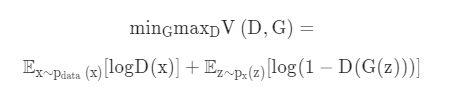

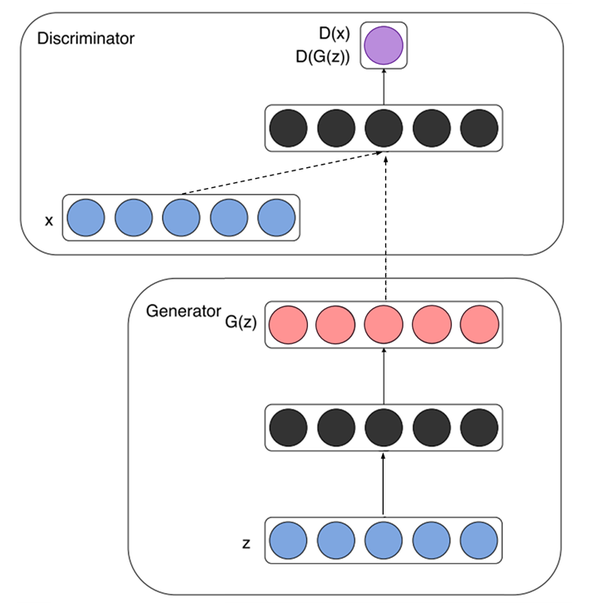

## CGAN의 목적함수

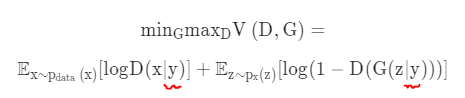

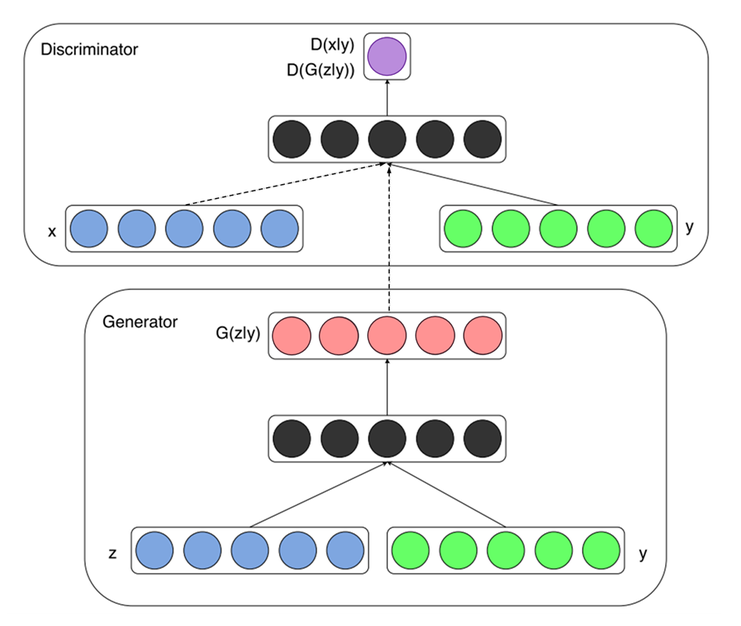

# Unimodal : y label에 대한 one-hot 정보

In [7]:
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
from tensorflow.keras import layers, Input, Model
from tensorflow.keras import optimizers, losses

Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


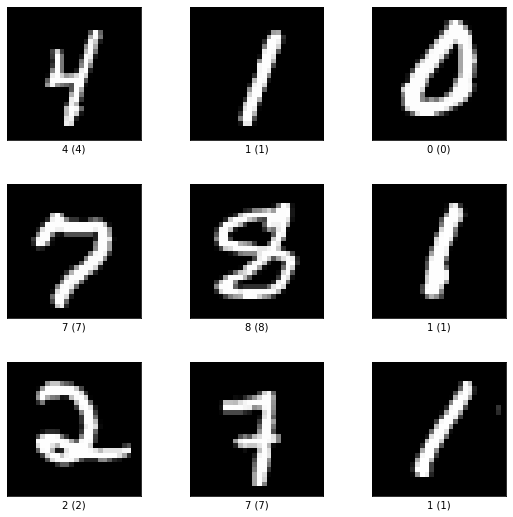

In [ ]:
mnist, info =  tfds.load(
    "mnist", split="train", with_info=True
)

fig = tfds.show_examples(mnist, info)

In [ ]:
BATCH_SIZE = 128

def cgan_preprocessing(data):
    image = data["image"]
    image = tf.cast(image, tf.float32)
    image = (image / 127.5) - 1 # -1 ~ 1
    
    label = tf.one_hot(data["label"], 10)
    return image, label

cgan_datasets = mnist.map(cgan_preprocessing).shuffle(100).batch(BATCH_SIZE)

Label : tf.Tensor([0. 0. 0. 0. 0. 0. 0. 0. 0. 1.], shape=(10,), dtype=float32)
Image Min/Max : -1.0 1.0


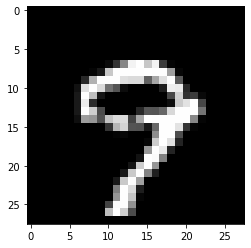

In [ ]:
for i,j in cgan_datasets : break

# 이미지 i와 라벨 j가 일치하는지 확인해 봅니다.     
print("Label :", j[0])
print("Image Min/Max :", i.numpy().min(), i.numpy().max())
plt.imshow(i.numpy()[0,...,0], plt.cm.gray)

In [ ]:
# class GeneratorCGAN(Model):
#     def __init__(self):
#         super(GeneratorCGAN, self).__init__()
        
#         self.dense_z = layers.Dense(256, activation='relu')
#         self.dense_y = layers.Dense(256, activation='relu')
#         self.combined_dense = layers.Dense(512, activation='relu')
#         self.final_dense = layers.Dense(28 * 28 * 1, activation='tanh')
#         self.reshape = layers.Reshape((28, 28, 1))

#     def call(self, noise, label):
#         noise = self.dense_z(noise)
#         label = self.dense_y(label)
#         out = self.combined_dense(tf.concat([noise, label], axis=-1))
#         out = self.final_dense(out)
#         return self.reshape(out)

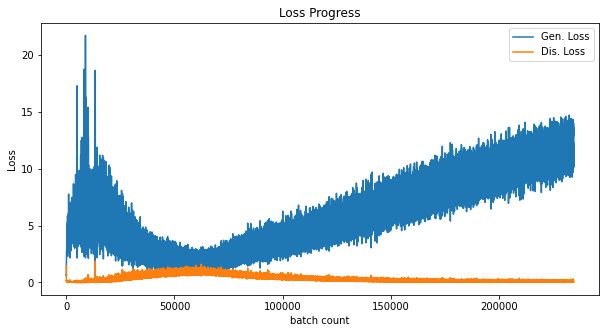

In [ ]:
class GeneratorCGAN(Model):
    def __init__(self):
        super(GeneratorCGAN, self).__init__()
        
        self.dense_z = layers.Dense(256) # 256 : 출력 뉴런의 수
        self.dense_y = layers.Dense(256)
        self.combined_dense = layers.Dense(512)
        self.leaky_relu = layers.LeakyReLU(0.2)
        self.final_dense = layers.Dense(28 * 28 * 1, activation='tanh')
        self.reshape = layers.Reshape((28, 28, 1))

    def call(self, noise, label):   # forward propagation 진행
        noise = self.dense_z(noise) # 노이즈 데이터의 feature들을 하나의 layer로 모음
        # 원래라면 Conv layer를 통과한 후의 추출된 feature들을 다 모으는 것이겠지만
        # 지금은 처음에 노이즈 데이터를 받는 Generator의 입장이므로..
        noise = self.leaky_relu(noise)

        label = self.dense_y(label)
        label = self.leaky_relu(label)

        out = self.combined_dense(tf.concat([noise, label], axis=-1))
        out = self.leaky_relu(out)

        out = self.final_dense(out)
        return self.reshape(out)

### Maxout layer

Maxout?

In [ ]:
class Maxout(layers.Layer):
    def __init__(self, units, pieces):
        super(Maxout, self).__init__()
        # units 차원 수를 가진 fully-connected 레이어를 pieces 개만큼 만들고, 그 중에 최댓값 출력
        # ex. Maxout(240, 5) : 240차원의 표현을 5개 linear한 형태로 만들고, 이 5개 중에서 최댓값을 가져와서 최종 1개의 240차원 표현을 출력

        self.dense = layers.Dense(units*pieces, activation="relu")
        self.dropout = layers.Dropout(.5)    
        self.reshape = layers.Reshape((-1, pieces, units))
    
    def call(self, x):
        x = self.dense(x)
        x = self.dropout(x)
        x = self.reshape(x)
        return tf.math.reduce_max(x, axis=2)

In [ ]:
class DiscriminatorCGAN(Model):
    def __init__(self):
        super(DiscriminatorCGAN, self).__init__()
        self.flatten = layers.Flatten() # 28 x 28 x 1 -> 576
        
        self.image_block = Maxout(240, 5) # 각각의 파라미터 값 자체에 대한 절대적인 의미는 없음!
        self.label_block = Maxout(50, 5)
        self.combine_block = Maxout(240, 4)
        
        self.dense = layers.Dense(1, activation=None)
        # 진짜 vs. 가짜를 판별하는 1개의 값이 출력됨
    
    def call(self, image, label):
        image = self.flatten(image)
        image = self.image_block(image) 
        # image와 label layer를 연결할 때, 여러 개의 fully-connected 레이어를 통과시켜 가장 큰 값을 가져오도록 함
        label = self.label_block(label)
        x = layers.Concatenate()([image, label]) ##
        x = self.combine_block(x)
        return self.dense(x)

# Training

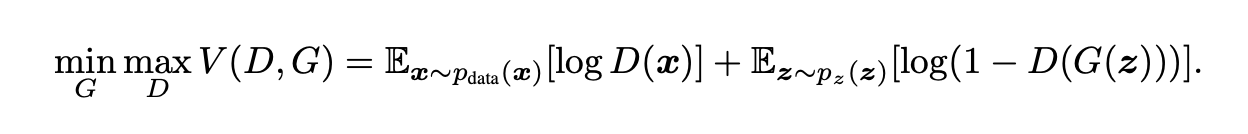

- generator_loss는 fake_output가 1에 가까워지기를 바라므로, 다음과 같이 tf.ones_like와의 교차 엔트로피값을 계산하면 됨
- 즉, bce(tf.ones_like(fake_output), fake_output) 값은fake_output이 (Real Image를 의미하는) 1에 가까울수록 작은 값을 가진다.
    
---
- discriminator_loss는 real_output 값은 1에 가까워지기를, fake_output 값은 0에 가까워지기를 바라므로, 두 가지 loss값을 모두 계산함
- real_output은 1로 채워진 벡터와, fake_output은 0으로 채워진 벡터와 비교해서 이 둘을 더한 값!!

In [ ]:
bce = losses.BinaryCrossentropy(from_logits=True)

def generator_loss(fake_output):
    return bce(tf.ones_like(fake_output), fake_output)

def discriminator_loss(real_output, fake_output):
    return bce(tf.ones_like(real_output), real_output) + bce(tf.zeros_like(fake_output), fake_output)

gen_opt = optimizers.Adam(1e-4)
dis_opt = optimizers.Adam(1e-4)

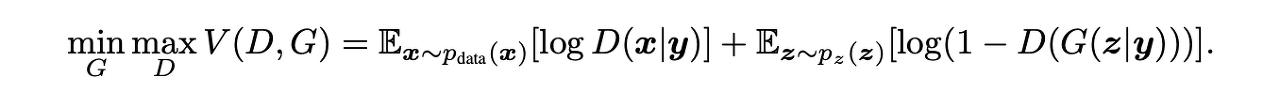

In [ ]:
cgan_generator = GeneratorCGAN()
cgan_discriminator = DiscriminatorCGAN()

@tf.function()
def cgan_step(real_images, labels):
    noise = tf.random.normal([real_images.shape[0], 100])
    
    with tf.GradientTape(persistent=True) as tape:
        fake_images = cgan_generator(noise, labels)
        
        real_out = cgan_discriminator(real_images, labels) ##
        fake_out = cgan_discriminator(fake_images, labels) ##
        
        gen_loss = generator_loss(fake_out)
        dis_loss = discriminator_loss(real_out, fake_out)
    
    gen_grad = tape.gradient(gen_loss, cgan_generator.trainable_variables)
    dis_grad = tape.gradient(dis_loss, cgan_discriminator.trainable_variables)
    
    gen_opt.apply_gradients(zip(gen_grad, cgan_generator.trainable_variables))
    dis_opt.apply_gradients(zip(dis_grad, cgan_discriminator.trainable_variables))
    return gen_loss, dis_loss

In [ ]:
loss_history={'gen':[], 'dis':[]}

EPOCHS = 500
for epoch in range(1, EPOCHS+1):
    
    for i, (images, labels) in enumerate(cgan_datasets):
        gen_loss, dis_loss = cgan_step(images, labels)
        loss_history['gen'].append(gen_loss)
        loss_history['dis'].append(dis_loss)
    
        if (i+1) % 469 == 0: # 60000 / 128(batch) = 468.75
            print(f"[{epoch}/{EPOCHS} EPOCHS, {i} ITER] G:{gen_loss}, D:{dis_loss}")

[1/500 EPOCHS, 468 ITER] G:3.8743855953216553, D:0.1046353429555893
[2/500 EPOCHS, 468 ITER] G:3.4707086086273193, D:0.08321641385555267
[3/500 EPOCHS, 468 ITER] G:4.537526607513428, D:0.039469774812459946
[4/500 EPOCHS, 468 ITER] G:4.009616374969482, D:0.0334823802113533
[5/500 EPOCHS, 468 ITER] G:3.97359561920166, D:0.09154990315437317
[6/500 EPOCHS, 468 ITER] G:4.651706218719482, D:0.1568579077720642
[7/500 EPOCHS, 468 ITER] G:3.805706739425659, D:0.11993430554866791
[8/500 EPOCHS, 468 ITER] G:5.795309543609619, D:0.11025070399045944
[9/500 EPOCHS, 468 ITER] G:4.579594612121582, D:0.07668542861938477
[10/500 EPOCHS, 468 ITER] G:5.648128509521484, D:0.06664562225341797
[11/500 EPOCHS, 468 ITER] G:4.8394365310668945, D:0.12165114283561707
[12/500 EPOCHS, 468 ITER] G:4.242818355560303, D:0.20243413746356964
[13/500 EPOCHS, 468 ITER] G:4.225008010864258, D:0.09300977736711502
[14/500 EPOCHS, 468 ITER] G:4.712176322937012, D:0.1305309385061264
[15/500 EPOCHS, 468 ITER] G:4.14248228073120

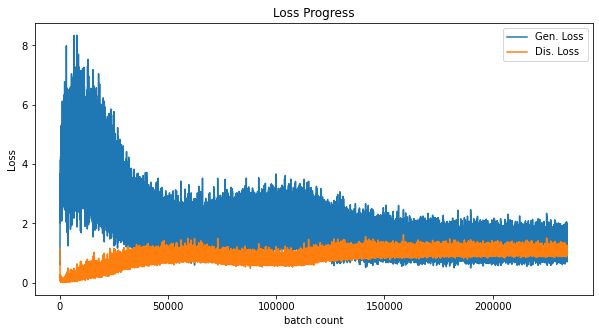

In [ ]:
# plot loss history
plt.figure(figsize=(10,5))
plt.title('Loss Progress')
plt.plot(loss_history['gen'], label='Gen. Loss')
plt.plot(loss_history['dis'], label='Dis. Loss')
plt.xlabel('batch count')
plt.ylabel('Loss')
plt.legend()
plt.show()

- discriminator가 점점 헷갈려 하는 것이 보임!!

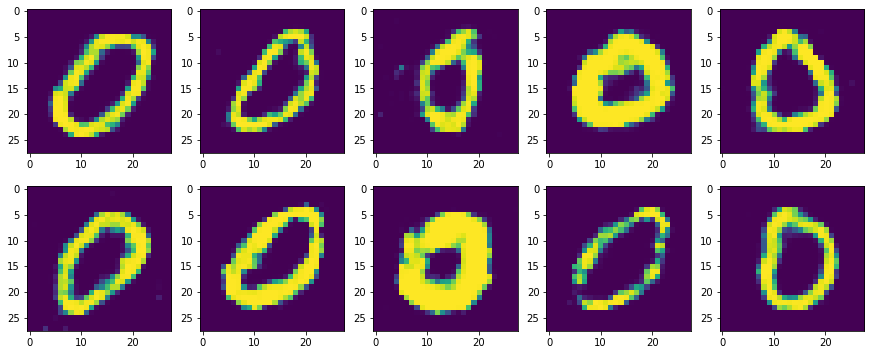

In [ ]:
number = 0  # 생성하고 싶은 숫자 입력!!

noise = tf.random.normal([10, 100])   # normal dist => shape : 10 x 100 (어쨌든 dense layer로 flatten하게 들어감)

label = tf.one_hot(number, 10)        # tf.Tensor([1. 0. 0. 0. 0. 0. 0. 0. 0. 0.], shape=(10,), dtype=float32)
label = tf.expand_dims(label, axis=0) # tf.Tensor([[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]], shape=(1, 10), dtype=float32)
label = tf.repeat(label, 10, axis=0)  # tf.Tensor([[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
                                      #            [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]                                    
                                      #            [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
                                      #            [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
                                      #            [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
                                      #            [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
                                      #            [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
                                      #            [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
                                      #            [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
                                      #            [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]], shape=(10, 10), dtype=float32)

# 충분한 epoch을 돌리지 않으면 원하는 숫자를 생성하지 못함!

output = cgan_generator(noise, label) # shape=(10, 28, 28, 1)
output = np.squeeze(output.numpy()) # shape=(10, 28, 28)

plt.figure(figsize=(15,6))
for i in range(1, 11):
    plt.subplot(2,5,i)
    plt.imshow(output[i-1])

- 500 epochs 생성 결과
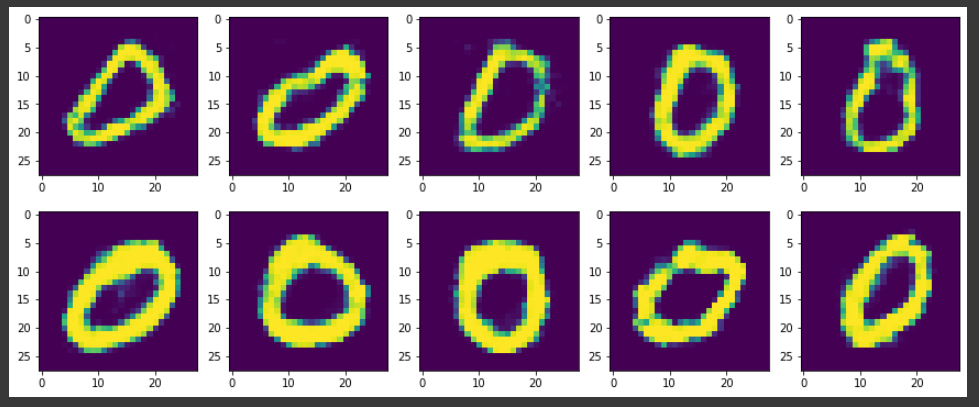

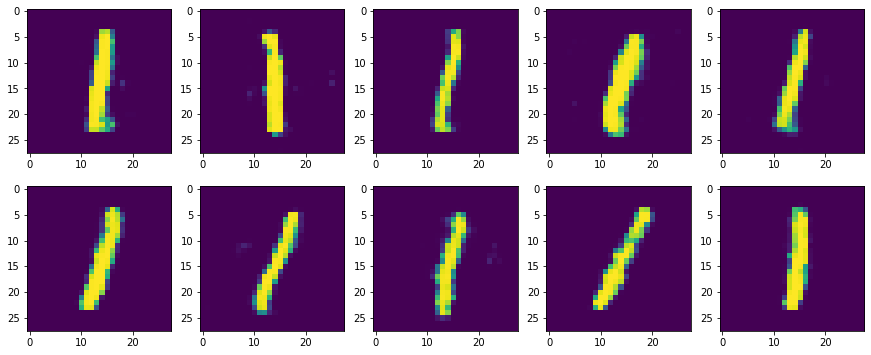

In [ ]:
number = 1  # 생성하고 싶은 숫자 입력!!

noise = tf.random.normal([10, 100])

label = tf.one_hot(number, 10)       
label = tf.expand_dims(label, axis=0)
label = tf.repeat(label, 10, axis=0)

output = cgan_generator(noise, label)
output = np.squeeze(output.numpy())

plt.figure(figsize=(15,6))
for i in range(1, 11):
    plt.subplot(2,5,i)
    plt.imshow(output[i-1])

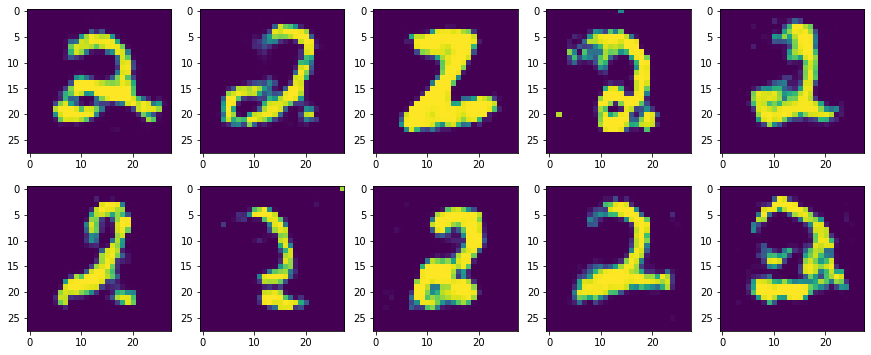

In [ ]:
number = 2  # 생성하고 싶은 숫자 입력!!

noise = tf.random.normal([10, 100])

label = tf.one_hot(number, 10)       
label = tf.expand_dims(label, axis=0)
label = tf.repeat(label, 10, axis=0)

output = cgan_generator(noise, label)
output = np.squeeze(output.numpy())

plt.figure(figsize=(15,6))
for i in range(1, 11):
    plt.subplot(2,5,i)
    plt.imshow(output[i-1])

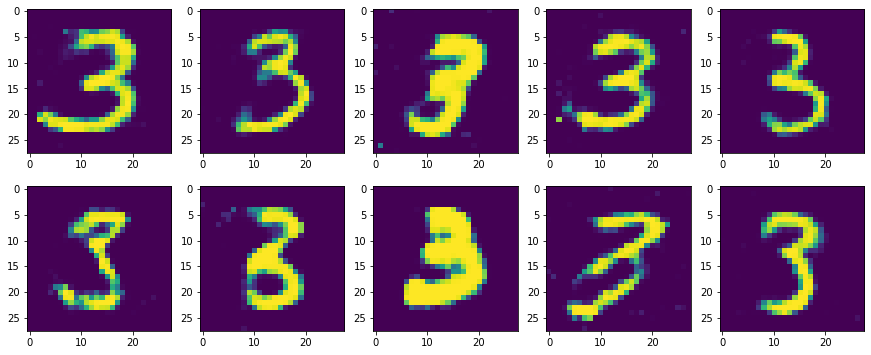

In [ ]:
number = 3  # 생성하고 싶은 숫자 입력!!

noise = tf.random.normal([10, 100])

label = tf.one_hot(number, 10)       
label = tf.expand_dims(label, axis=0)
label = tf.repeat(label, 10, axis=0)

output = cgan_generator(noise, label)
output = np.squeeze(output.numpy())

plt.figure(figsize=(15,6))
for i in range(1, 11):
    plt.subplot(2,5,i)
    plt.imshow(output[i-1])

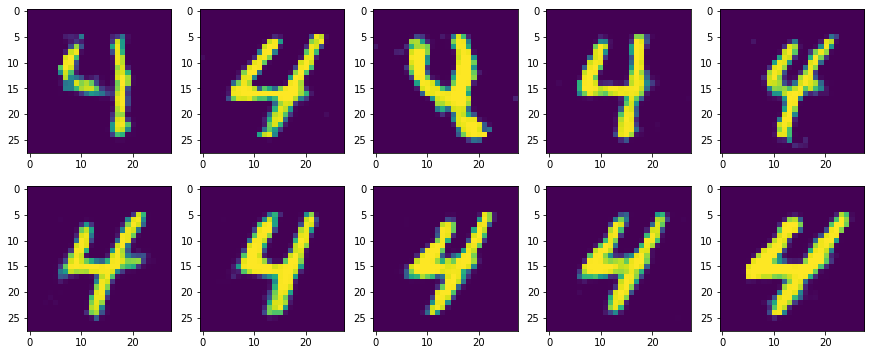

In [ ]:
number = 4  # 생성하고 싶은 숫자 입력!!

noise = tf.random.normal([10, 100])

label = tf.one_hot(number, 10)       
label = tf.expand_dims(label, axis=0)
label = tf.repeat(label, 10, axis=0)

output = cgan_generator(noise, label)
output = np.squeeze(output.numpy())

plt.figure(figsize=(15,6))
for i in range(1, 11):
    plt.subplot(2,5,i)
    plt.imshow(output[i-1])

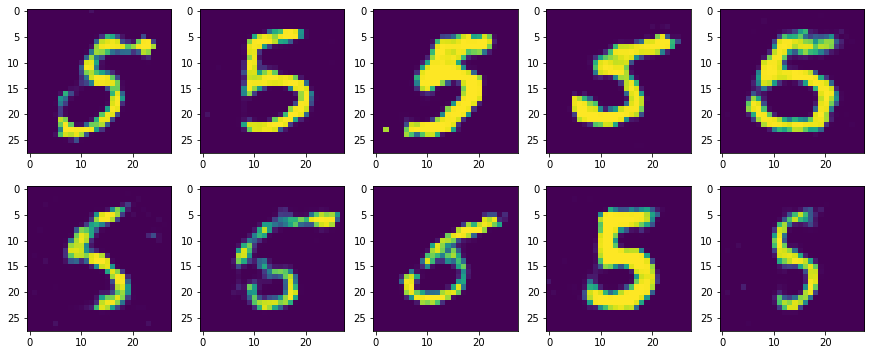

In [ ]:
number = 5  # 생성하고 싶은 숫자 입력!!

noise = tf.random.normal([10, 100])

label = tf.one_hot(number, 10)       
label = tf.expand_dims(label, axis=0)
label = tf.repeat(label, 10, axis=0)

output = cgan_generator(noise, label)
output = np.squeeze(output.numpy())

plt.figure(figsize=(15,6))
for i in range(1, 11):
    plt.subplot(2,5,i)
    plt.imshow(output[i-1])

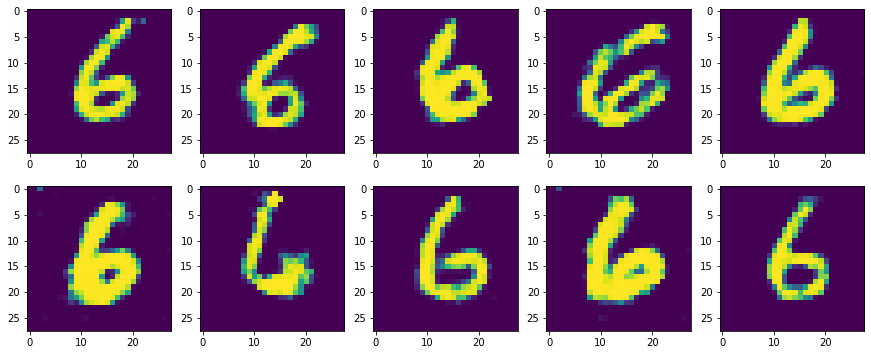

In [ ]:
number = 6  # 생성하고 싶은 숫자 입력!!

noise = tf.random.normal([10, 100])

label = tf.one_hot(number, 10)       
label = tf.expand_dims(label, axis=0)
label = tf.repeat(label, 10, axis=0)

output = cgan_generator(noise, label)
output = np.squeeze(output.numpy())

plt.figure(figsize=(15,6))
for i in range(1, 11):
    plt.subplot(2,5,i)
    plt.imshow(output[i-1])

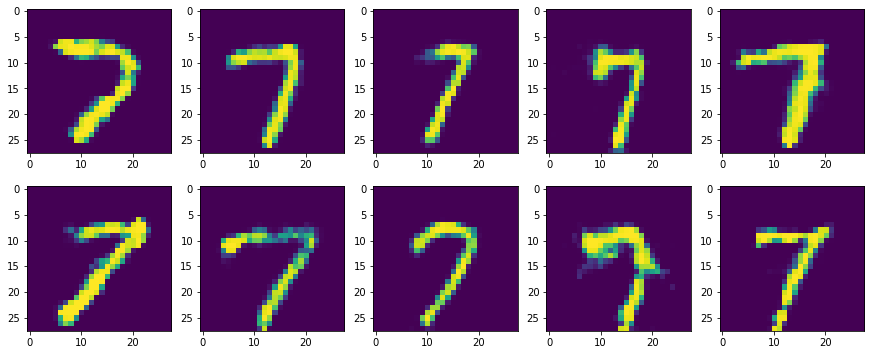

In [ ]:
number = 7  # 생성하고 싶은 숫자 입력!!

noise = tf.random.normal([10, 100])

label = tf.one_hot(number, 10)       
label = tf.expand_dims(label, axis=0)
label = tf.repeat(label, 10, axis=0)

output = cgan_generator(noise, label)
output = np.squeeze(output.numpy())

plt.figure(figsize=(15,6))
for i in range(1, 11):
    plt.subplot(2,5,i)
    plt.imshow(output[i-1])

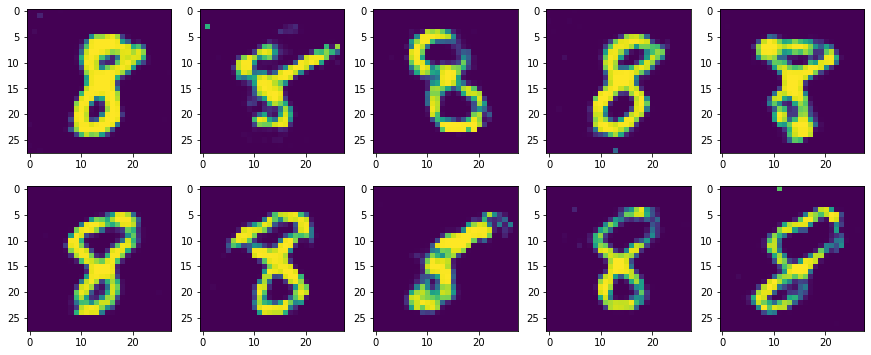

In [ ]:
number = 8  # 생성하고 싶은 숫자 입력!!

noise = tf.random.normal([10, 100])

label = tf.one_hot(number, 10)       
label = tf.expand_dims(label, axis=0)
label = tf.repeat(label, 10, axis=0)

output = cgan_generator(noise, label)
output = np.squeeze(output.numpy())

plt.figure(figsize=(15,6))
for i in range(1, 11):
    plt.subplot(2,5,i)
    plt.imshow(output[i-1])

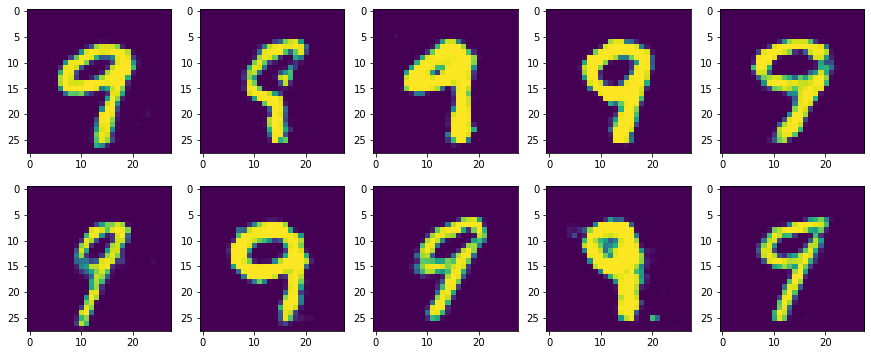

In [ ]:
number = 9  # 생성하고 싶은 숫자 입력!!

noise = tf.random.normal([10, 100])

label = tf.one_hot(number, 10)       
label = tf.expand_dims(label, axis=0)
label = tf.repeat(label, 10, axis=0)

output = cgan_generator(noise, label)
output = np.squeeze(output.numpy())

plt.figure(figsize=(15,6))
for i in range(1, 11):
    plt.subplot(2,5,i)
    plt.imshow(output[i-1])

### Pretrained_model로 결과 출력해보기

https://drive.google.com/drive/folders/1VXmyzkrhyVahJ_QPg5ZT_kT6opoIDmin?usp=sharing

In [ ]:
class GeneratorCGAN(Model):
    def __init__(self):
        super(GeneratorCGAN, self).__init__()
        
        self.dense_z = layers.Dense(256, activation='relu')
        self.dense_y = layers.Dense(256, activation='relu')
        self.combined_dense = layers.Dense(512, activation='relu')
        self.final_dense = layers.Dense(28 * 28 * 1, activation='tanh')
        self.reshape = layers.Reshape((28, 28, 1))

    def call(self, noise, label):
        noise = self.dense_z(noise)
        label = self.dense_y(label)
        out = self.combined_dense(tf.concat([noise, label], axis=-1))
        out = self.final_dense(out)
        return self.reshape(out)

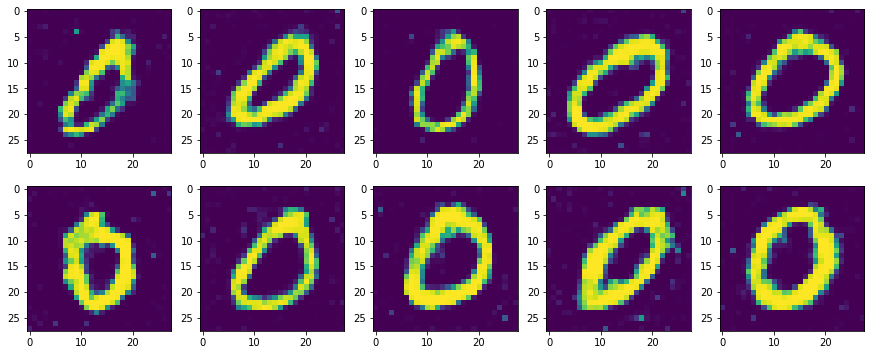

In [ ]:
number = 0  # TODO : 생성할 숫자를 입력해 주세요!!

weight_path = '/content/drive/MyDrive/CGAN_500/CGAN_500' # 경로 설정 주의

noise = tf.random.normal([10, 100])

label = tf.one_hot(number, 10)
label = tf.expand_dims(label, axis=0)
label = tf.repeat(label, 10, axis=0)

generator = GeneratorCGAN()
generator.load_weights(weight_path)

output = generator(noise, label)
output = np.squeeze(output.numpy())

plt.figure(figsize=(15,6))
for i in range(1, 11):
    plt.subplot(2,5,i)
    plt.imshow(output[i-1])

# Multimodal: Word vector와 같은 다른 양식의 데이터를 추가로 제공 
ex) **Pix2Pix**, cycleGAN

Unimodal에서 label 정보만 주었다면, 이번에는 그림 정보 자체를 주는 것!

In [35]:
import cv2
import os
from tensorflow import data
from tensorflow import image
from tensorflow.keras.preprocessing.image import random_rotation
from tensorflow.keras import losses
from tensorflow.keras import optimizers

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [11]:
# https://www.kaggle.com/datasets/norod78/sketch2pokemon
data_path = '/content/drive/MyDrive/pokemon_pix2pix_dataset/train/'
print("number of train examples :", len(os.listdir(data_path)))

number of train examples : 830


(256, 512, 3)


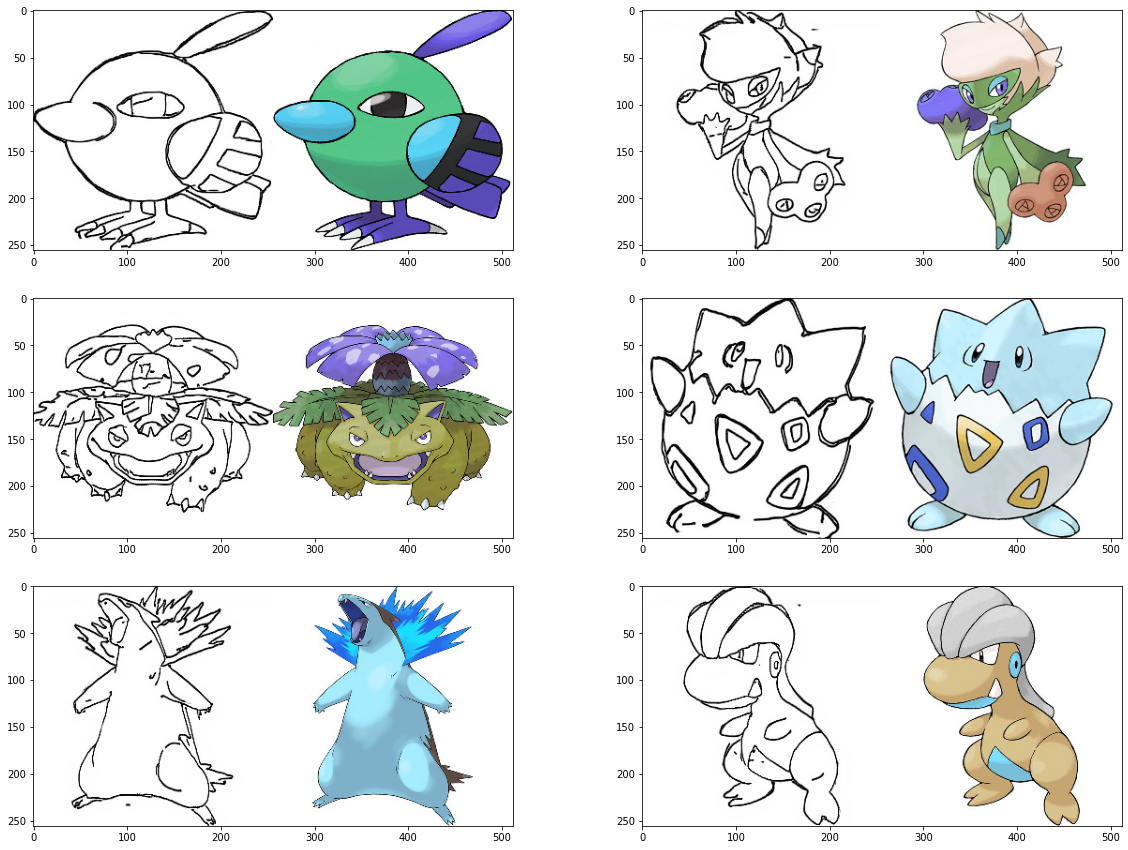

In [14]:
plt.figure(figsize=(20,15))
for i in range(1, 7):
    f = data_path + os.listdir(data_path)[np.random.randint(800)]
    img = cv2.imread(f, cv2.IMREAD_COLOR)
    
    plt.subplot(3,2,i)
    plt.imshow(img)

    if i == 6:
      print(img.shape) # 이미지 사이즈

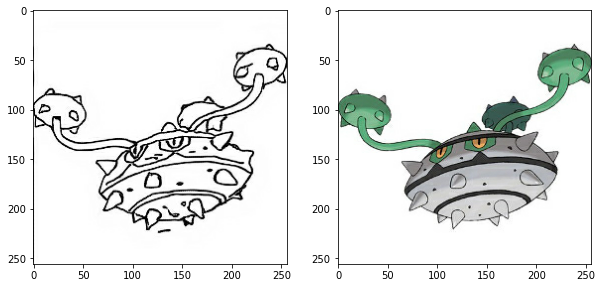

In [15]:
def normalize(x):
    x = tf.cast(x, tf.float32)
    return (x/127.5) - 1

def denormalize(x):
    x = (x+1)*127.5
    x = x.numpy()
    return x.astype(np.uint8)

def load_img(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, 3)
    
    w = tf.shape(img)[1] // 2
    sketch = img[:, :w, :] 
    sketch = tf.cast(sketch, tf.float32)
    colored = img[:, w:, :] 
    colored = tf.cast(colored, tf.float32)
    return normalize(sketch), normalize(colored)

f = data_path + os.listdir(data_path)[1]
sketch, colored = load_img(f)

plt.figure(figsize=(10,7))
plt.subplot(1,2,1); plt.imshow(denormalize(sketch))
plt.subplot(1,2,2); plt.imshow(denormalize(colored))

In [17]:
@tf.function()
def apply_augmentation(sketch, colored):
    stacked = tf.concat([sketch, colored], axis=-1)
    
    _pad = tf.constant([[30,30],[30,30],[0,0]])
    if tf.random.uniform(()) < .5:
        padded = tf.pad(stacked, _pad, "REFLECT") # 이미지 전처리 중 shape 통일을 위해 원본 이미지에 zero-padding을 해야하는 경우가 있음
    else:
        padded = tf.pad(stacked, _pad, "CONSTANT", constant_values=1.)

    out = image.random_crop(padded, size=[256, 256, 6])
    
    out = image.random_flip_left_right(out)
    out = image.random_flip_up_down(out)
    
    if tf.random.uniform(()) < .5:
        degree = tf.random.uniform([], minval=1, maxval=4, dtype=tf.int32)
        out = image.rot90(out, k=degree)
    
    return out[...,:3], out[...,3:]   


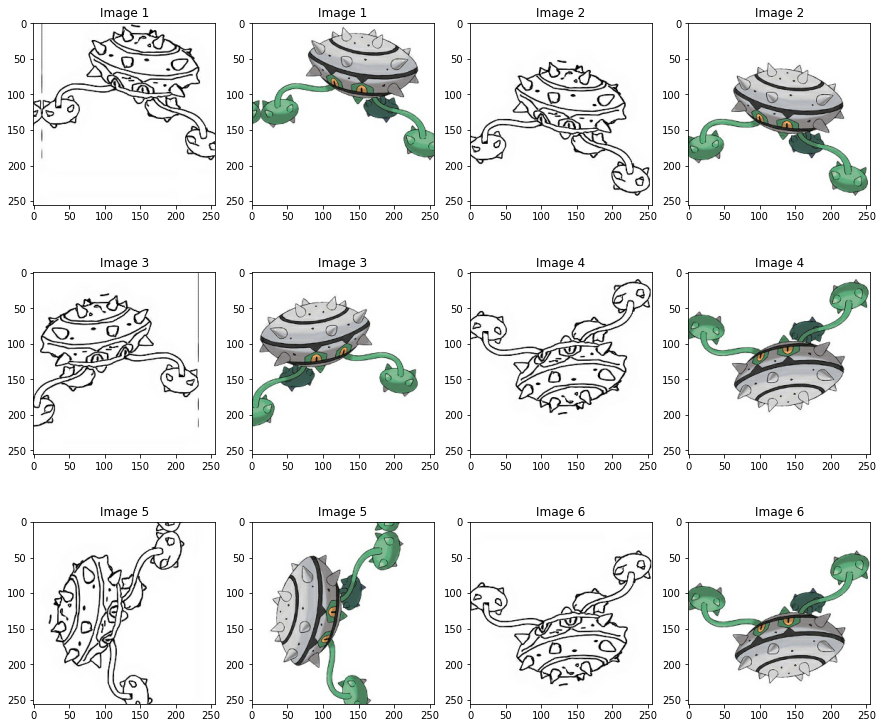

In [18]:
plt.figure(figsize=(15,13))
img_n = 1
for i in range(1, 13, 2):
    augmented_sketch, augmented_colored = apply_augmentation(sketch, colored)
    
    plt.subplot(3,4,i)
    plt.imshow(denormalize(augmented_sketch)); plt.title(f"Image {img_n}")
    plt.subplot(3,4,i+1); 
    plt.imshow(denormalize(augmented_colored)); plt.title(f"Image {img_n}")
    img_n += 1

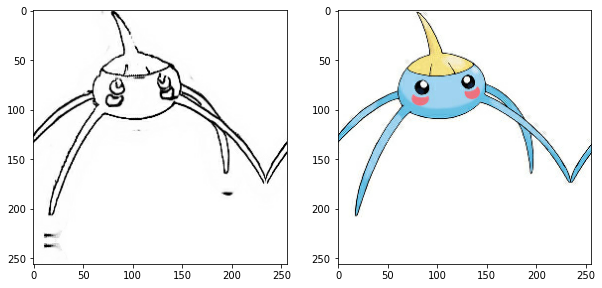

In [19]:
def get_train(img_path):
    sketch, colored = load_img(img_path)
    sketch, colored = apply_augmentation(sketch, colored)
    return sketch, colored

train_images = data.Dataset.list_files(data_path + "*.jpg")
train_images = train_images.map(get_train).shuffle(100).batch(4)

sample = train_images.take(1)
sample = list(sample.as_numpy_iterator())
sketch, colored = (sample[0][0]+1)*127.5, (sample[0][1]+1)*127.5

plt.figure(figsize=(10,5))
plt.subplot(1,2,1); plt.imshow(sketch[0].astype(np.uint8))
plt.subplot(1,2,2); plt.imshow(colored[0].astype(np.uint8))

### Pix2Pix Generator

Generator는 어떤 이미지를 입력받아서 변환된 이미지를 출력
- 입력 이미지와 변환된 이미지의 크기는 동일해야 함.
- 이러한 문제에서 흔히 사용되는 구조는 인코더-디코더 구조


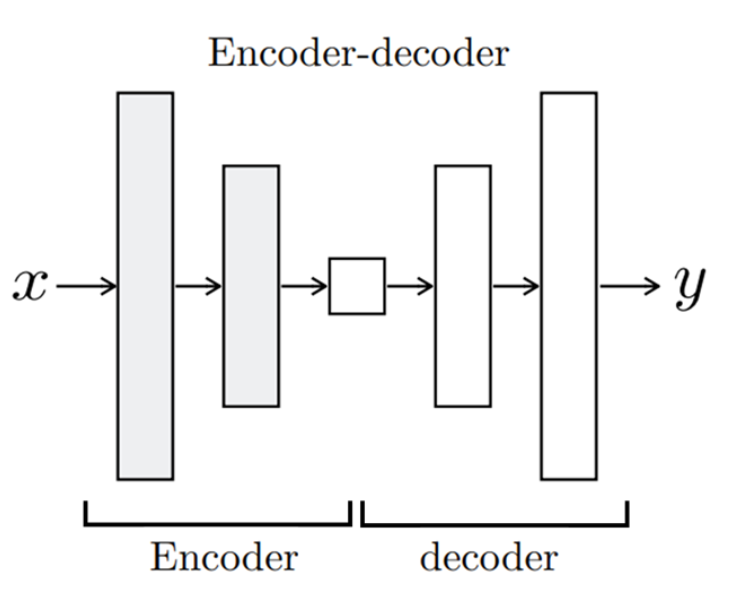

In [27]:
class EncodeBlock(layers.Layer):
    def __init__(self, n_filters, use_bn=True):
        super(EncodeBlock, self).__init__()
        self.use_bn = use_bn       
        self.conv = layers.Conv2D(n_filters, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.lrelu = layers.LeakyReLU(0.2)

    def call(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.batchnorm(x)
        return self.lrelu(x)

In [28]:
class DecodeBlock(layers.Layer):
    def __init__(self, f, dropout=True):
        super(DecodeBlock, self).__init__()
        self.dropout = dropout
        self.Transconv = layers.Conv2DTranspose(f, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.relu = layers.ReLU()
        
    def call(self, x):
        x = self.Transconv(x)
        x = self.batchnorm(x)
        if self.dropout:
            x = layers.Dropout(.5)(x)
        return self.relu(x)

In [29]:
# Encoder-Decoder 구조는 Unet구조를 활용
class UNetGenerator(Model):
    def __init__(self):
        super(UNetGenerator, self).__init__()
        encode_filters = [64,128,256,512,512,512,512,512]
        decode_filters = [512,512,512,512,256,128,64]
        
        self.encode_blocks = []
        for i, f in enumerate(encode_filters):
            if i == 0:
                self.encode_blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.encode_blocks.append(EncodeBlock(f))
        
        self.decode_blocks = []
        for i, f in enumerate(decode_filters):
            if i < 3:
                self.decode_blocks.append(DecodeBlock(f))
            else:
                self.decode_blocks.append(DecodeBlock(f, dropout=False))
        
        self.last_conv = layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False)
    
    def call(self, x):
        features = []
        for block in self.encode_blocks:
            x = block(x)
            features.append(x)
        
        features = features[:-1]
                    
        for block, feat in zip(self.decode_blocks, features[::-1]):
            x = block(x)
            x = layers.Concatenate()([x, feat])
        
        x = self.last_conv(x)
        return x
                
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

In [30]:
UNetGenerator().get_summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 encode_block_16 (EncodeBlock)  (None, 128, 128, 64  3072        ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 encode_block_17 (EncodeBlock)  (None, 64, 64, 128)  131584      ['encode_block_16[0][0]']        
                                                                                            

### Pix2Pix Discriminator


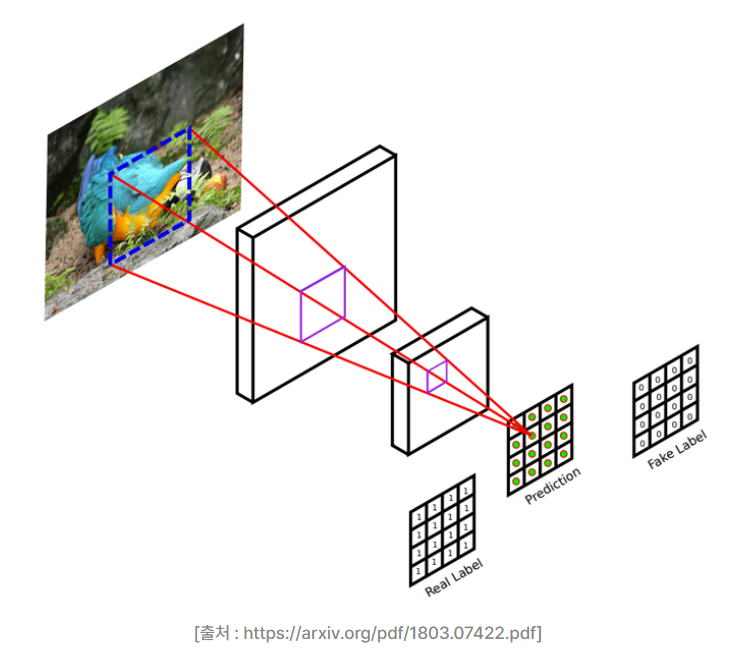

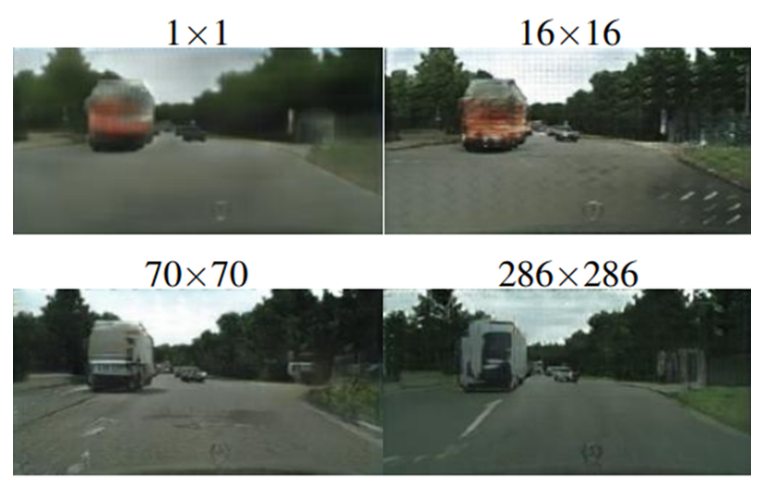

In [31]:
class DiscBlock(layers.Layer):
    def __init__(self, n_filters, stride=2, custom_pad=False, use_bn=True, act=True):
        super(DiscBlock, self).__init__()
        self.custom_pad = custom_pad
        self.use_bn = use_bn
        self.act = act
        
        if custom_pad:
            self.padding = layers.ZeroPadding2D()
            self.conv = layers.Conv2D(n_filters, 4, stride, "valid", use_bias=False)
        else:
            self.conv = layers.Conv2D(n_filters, 4, stride, "same", use_bias=False)
        
        self.batchnorm = layers.BatchNormalization() if use_bn else None
        self.lrelu = layers.LeakyReLU(0.2) if act else None
        
    def call(self, x):
        if self.custom_pad:
            x = self.padding(x)
            x = self.conv(x)
        else:
            x = self.conv(x)
                
        if self.use_bn:
            x = self.batchnorm(x)
            
        if self.act:
            x = self.lrelu(x)
        return x 

In [32]:
class Discriminator(Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.block1 = layers.Concatenate()
        self.block2 = DiscBlock(n_filters=64, stride=2, custom_pad=False, use_bn=False, act=True)
        self.block3 = DiscBlock(n_filters=128, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block4 = DiscBlock(n_filters=256, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block5 = DiscBlock(n_filters=512, stride=1, custom_pad=True, use_bn=True, act=True)
        self.block6 = DiscBlock(n_filters=1, stride=1, custom_pad=True, use_bn=False, act=False)
        self.sigmoid = layers.Activation("sigmoid")
        
        # filters = [64,128,256,512,1]
        # self.blocks = [layers.Concatenate()]
        # for i, f in enumerate(filters):
        #     self.blocks.append(DiscBlock(
        #         n_filters=f,
        #         strides=2 if i<3 else 1,
        #         custom_pad=False if i<3 else True,
        #         use_bn=False if i==0 and i==4 else True,
        #         act=True if i<4 else False
        #     ))
    
    def call(self, x, y):
        out = self.block1([x, y])
        out = self.block2(out)
        out = self.block3(out)
        out = self.block4(out)
        out = self.block5(out)
        out = self.block6(out)
        return self.sigmoid(out)
    
    def get_summary(self, x_shape=(256,256,3), y_shape=(256,256,3)):
        x, y = Input(x_shape), Input(y_shape) 
        return Model((x, y), self.call(x, y)).summary()

In [33]:
Discriminator().get_summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_6 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 concatenate_7 (Concatenate)    (None, 256, 256, 6)  0           ['input_5[0][0]',                
                                                                  'input_6[0][0]']          

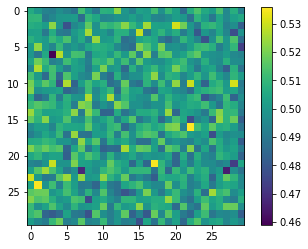

In [34]:
# (256, 256, 3) -> (30, 30) 출력

x = tf.random.normal([1,256,256,3])
y = tf.random.uniform([1,256,256,3])

disc_out = Discriminator()(x, y)
plt.imshow(disc_out[0, ... ,0])
plt.colorbar()

### Pix2Pix Loss function
- l1 loss + GAN loss

In [36]:
bce = losses.BinaryCrossentropy(from_logits=False)
mae = losses.MeanAbsoluteError()

def get_gene_loss(fake_output, real_output, fake_disc):
    l1_loss = mae(real_output, fake_output)
    gene_loss = bce(tf.ones_like(fake_disc), fake_disc)
    return gene_loss, l1_loss

def get_disc_loss(fake_disc, real_disc):
    return bce(tf.zeros_like(fake_disc), fake_disc) + bce(tf.ones_like(real_disc), real_disc)

In [37]:
gene_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)
disc_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)

In [38]:
@tf.function
def train_step(sketch, real_colored):
    with tf.GradientTape() as gene_tape, tf.GradientTape() as disc_tape:
        # Generator 예측
        fake_colored = generator(sketch, training=True)
        # Discriminator 예측
        fake_disc = discriminator(sketch, fake_colored, training=True)
        real_disc = discriminator(sketch, real_colored, training=True)
        # Generator 손실 계산
        gene_loss, l1_loss = get_gene_loss(fake_colored, real_colored, fake_disc)
        gene_total_loss = gene_loss + (100 * l1_loss) ## <===== L1 손실 반영 λ=100
        # Discrminator 손실 계산
        disc_loss = get_disc_loss(fake_disc, real_disc)
                
    gene_gradient = gene_tape.gradient(gene_total_loss, generator.trainable_variables)
    disc_gradient = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    gene_opt.apply_gradients(zip(gene_gradient, generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_gradient, discriminator.trainable_variables))
    return gene_loss, l1_loss, disc_loss

In [39]:
EPOCHS = 10

generator = UNetGenerator()
discriminator = Discriminator()

for epoch in range(1, EPOCHS+1):
    for i, (sketch, colored) in enumerate(train_images):
        g_loss, l1_loss, d_loss = train_step(sketch, colored)
                
        # 10회 반복마다 손실을 출력합니다.
        if (i+1) % 10 == 0:
            print(f"EPOCH[{epoch}] - STEP[{i+1}] \
                    \nGenerator_loss:{g_loss.numpy():.4f} \
                    \nL1_loss:{l1_loss.numpy():.4f} \
                    \nDiscriminator_loss:{d_loss.numpy():.4f}", end="\n\n")

EPOCH[1] - STEP[10]                     
Generator_loss:0.9143                     
L1_loss:0.5231                     
Discriminator_loss:1.2149

EPOCH[1] - STEP[20]                     
Generator_loss:1.0511                     
L1_loss:0.2920                     
Discriminator_loss:1.3833

EPOCH[1] - STEP[30]                     
Generator_loss:0.9504                     
L1_loss:0.2500                     
Discriminator_loss:1.1307

EPOCH[1] - STEP[40]                     
Generator_loss:1.3792                     
L1_loss:0.2328                     
Discriminator_loss:1.1551

EPOCH[1] - STEP[50]                     
Generator_loss:1.3831                     
L1_loss:0.2698                     
Discriminator_loss:0.7291

EPOCH[1] - STEP[60]                     
Generator_loss:2.0423                     
L1_loss:0.2393                     
Discriminator_loss:0.8974

EPOCH[1] - STEP[70]                     
Generator_loss:2.2794                     
L1_loss:0.2770                    

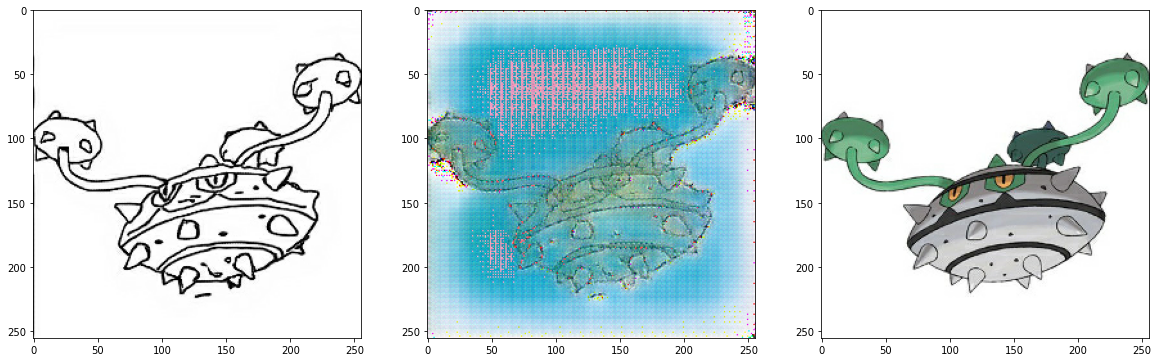

In [40]:
test_ind = 1

f = data_path + os.listdir(data_path)[test_ind]
sketch, colored = load_img(f)

pred = generator(tf.expand_dims(sketch, 0))
pred = denormalize(pred)

plt.figure(figsize=(20,10))
plt.subplot(1,3,1); plt.imshow(denormalize(sketch))
plt.subplot(1,3,2); plt.imshow(pred[0])
plt.subplot(1,3,3); plt.imshow(denormalize(colored))